In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.4.1'

In [2]:
import cv2

In [27]:
DATA_DIR = 'numbers'  # 100 images
H, W, C = 136, 47, 3
N_LABELS = 10
D = 3

2

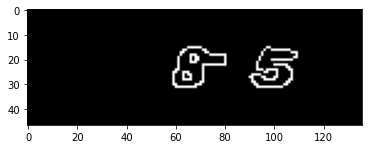

In [4]:
file = "captcha_error/001.png"
label = "8-5" #parse_filepath(file)
image = cv2.imread(file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 50, 40, L2gradient=True)
plt.imshow(canny, cmap="gray")
contours, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

2

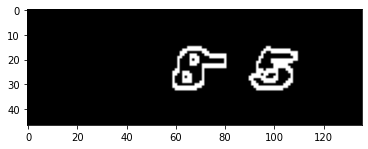

In [5]:
dilated = cv2.dilate(canny, (2, 2), iterations=1)
contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(dilated, cmap="gray")
len(contours)

contours:  2


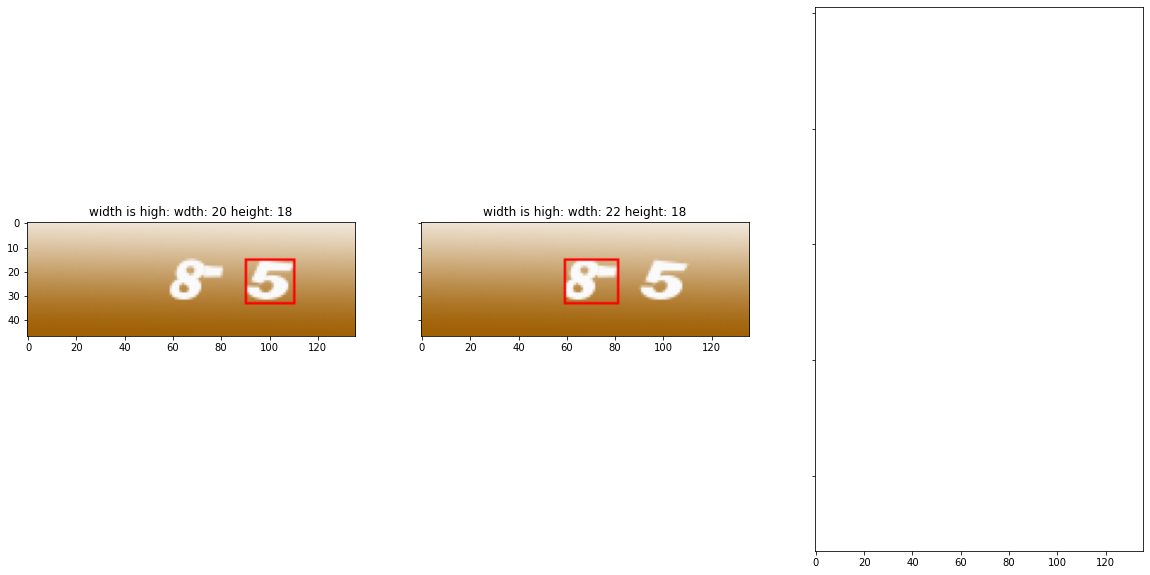

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

count = 0
for i, contour in enumerate(contours):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    (x, y, w, h) = cv2.boundingRect(contour)
    
    ax[i].imshow(cv2.rectangle(image, (x, y), (x+w,y+h), (255, 0, 0), 1), "gray")
    
    if (5 <= w <= 19) and (5 <= h <= 19):
        ax[i].set_title(f"perfect: wdth: {w} height: {h}")
        count += 1
    elif w > 19:
        value = round(w/16)
        ax[i].set_title(f"width is high: wdth: {w} height: {h}")
        count += value
    elif h > 19:
        value = round(h/16)
        ax[i].set_title(f"height is high: wdth: {w} height: {h}")
        count += value
    else:
        ax[i].set_title(f"skipped: wdth: {w} height: {h}")

print("contours: ", len(contours))
plt.show()

In [12]:
letter_image_regions = []
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    if (5 <= w <= 20) and (4 <= h <= 21):
        letter_image_regions.append((x, y, w, h))
    elif w > 20:
        half_width = int(w / 2) + 3
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
len(letter_image_regions)

3

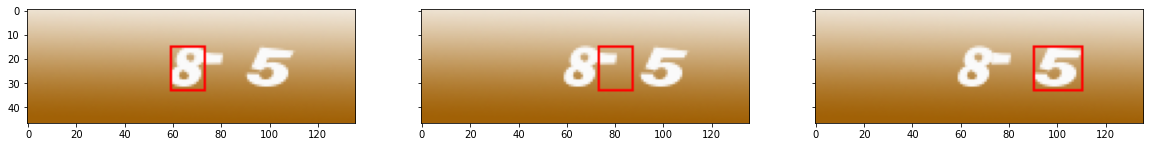

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
for i, (x, y, w, h) in enumerate(letter_image_regions):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    ax[i].imshow(cv2.rectangle(image, (x, y), (x+w,y+h), (255, 0, 0), 1), "gray")

plt.show()   

In [14]:
counts = {}
for letter_bounding_box, letter_text in zip(letter_image_regions, label):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        save_path = os.path.join("extract_captcha", letter_text)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

In [15]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense


In [16]:
import imutils
import cv2


def resize_to_fit(image, width, height):
    (h, w) = image.shape[:2]

    if w > h:
        image = imutils.resize(image, width=width)
    else:
        image = imutils.resize(image, height=height)

    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    return image

In [244]:
LETTER_IMAGES_FOLDER = "extracted_numbers"
MODEL_FILENAME = "number_model.hdf5"
MODEL_LABELS_FILENAME = "number_model_labels.dat"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

In [246]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [248]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=0)

In [249]:
print("Shape of Training Image Data: " + str(X_train.shape))
print("Shape of Training Class Data: " + str(Y_train.shape))
print("Shape of Test Image Data: " + str(X_test.shape))
print("Shape of Test Class Data: " + str(Y_test.shape))

Shape of Training Image Data: (487, 20, 20, 1)
Shape of Training Class Data: (487,)
Shape of Test Image Data: (122, 20, 20, 1)
Shape of Test Class Data: (122,)


In [250]:
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

In [251]:
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [252]:
Y_test

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [253]:
# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(10, activation="softmax"))
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 50)        25050     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               625500    
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [254]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=16, epochs=10, verbose=1)

Epoch 1/10
31/31 [==============================] - 2s 27ms/step - loss: 2.1925 - accuracy: 0.2007 - val_loss: 1.9041 - val_accuracy: 0.3279
Epoch 2/10
31/31 [==============================] - 1s 17ms/step - loss: 1.5798 - accuracy: 0.4578 - val_loss: 0.6085 - val_accuracy: 0.9836
Epoch 3/10
31/31 [==============================] - 0s 16ms/step - loss: 0.4420 - accuracy: 0.9560 - val_loss: 0.1404 - val_accuracy: 0.9754
Epoch 4/10
31/31 [==============================] - 1s 17ms/step - loss: 0.1101 - accuracy: 0.9759 - val_loss: 0.0550 - val_accuracy: 0.9918
Epoch 5/10
31/31 [==============================] - 1s 22ms/step - loss: 0.0681 - accuracy: 0.9904 - val_loss: 0.0444 - val_accuracy: 0.9836
Epoch 6/10
31/31 [==============================] - 1s 16ms/step - loss: 0.0306 - accuracy: 0.9950 - val_loss: 0.0232 - val_accuracy: 0.9918
Epoch 7/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0462 - accuracy: 0.9848 - val_loss: 0.0595 - val_accuracy: 0.9836
Epoch 8/10
31

In [255]:
model.save(MODEL_FILENAME)

In [258]:
predicted_classes = model.predict_classes(X_test)
predicted_classes

/home/dedsec/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 0, 1, 3, 4, 4, 3, 3, 2, 8, 3, 1, 9, 3, 8, 7, 7, 1, 7, 1, 4, 0,
       0, 7, 9, 1, 2, 9, 2, 3, 3, 3, 8, 2, 6, 7, 7, 1, 7, 3, 0, 2, 5, 3,
       1, 1, 0, 3, 5, 7, 3, 8, 1, 6, 8, 9, 3, 3, 5, 2, 6, 0, 8, 5, 7, 5,
       0, 4, 7, 9, 7, 3, 1, 0, 5, 0, 3, 5, 1, 4, 1, 8, 1, 3, 9, 1, 1, 5,
       3, 0, 4, 5, 0, 4, 3, 4, 9, 3, 4, 9, 1, 2, 0, 1, 7, 5, 7, 4, 5, 2,
       2, 8, 4, 5, 0, 7, 1, 7, 0, 1, 0, 9])

In [259]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
